# Variable SSA C Solver

### The Variable SSA C Solver provides optimization for running multiple simulations of a model with variable parameter values and/or Species initial values.  This is ideal for parameter sweeps, or model exploration.

In [1]:
import sys
sys.path.append('../../../GillesPy2')
import numpy as np
import libsbml
from gillespy2.core import Model, Species, Reaction, Parameter
import gillespy2
from gillespy2.core.events import *
from gillespy2.solvers.cpp.variable_ssa_c_solver import VariableSSACSolver

In [2]:
# Model Definition
class HISRD(Model):   
                                                                                                                                                                                                                                     
    def __init__(self, start_time = 0,
                       dt = 1.0,
                       end_time = 42.0):                                                                                                                                                                                       
        
        # Initialize the model.                                                                                                                                                                                                      
        Model.__init__(self, name="Example")                                                                                                                                                                                         

        # Species                                                                                                                                                                                             
        healthy = Species(name='healthy', initial_value=10000)
        infected = Species(name='infected', initial_value=1)
        symptomatic = Species(name='symptomatic', initial_value=0)
        dead = Species(name='dead', initial_value=0)
        recovered = Species(name='recovered', initial_value=0)
        self.add_species([healthy, infected, symptomatic, dead, recovered])
        
        
        # Parameters                                                                                                                                                                                                                 
        infect = Parameter(name='infect', expression=np.exp(np.log(0.0002)))
        progress = Parameter(name='progress', expression=np.exp(np.log(0.071)))
        recovery = Parameter(name='recovery', expression=np.exp(np.log(0.8)))
        death = Parameter(name='death', expression=np.exp(np.log(0.2)))
        self.add_parameter([infect, progress, recovery, death])
        
        #Reactions
        r2 = Reaction(name='r2', reactants={healthy:1, infected:1}, products={infected:2}, rate=infect)
        r3 = Reaction(name='r3', reactants={healthy:1, symptomatic:1}, products={infected:1, symptomatic:1}, rate=infect)
        r4 = Reaction(name='r4', reactants={infected:1}, products={symptomatic:1}, rate=progress)
        r5 = Reaction(name='r5', reactants={symptomatic:1}, products={dead:1}, rate=death)
        r6 = Reaction(name='r6', reactants={symptomatic:1}, products={recovered:1}, rate=recovery)
        self.add_reaction([r2, r3, r4, r5, r6])


        self.timespan(np.arange(start_time, end_time + dt, dt))

### In order to maximize the benefits of the variable ssa solver, we must first instantiate our model and solver.  This will pre-compile the simulation, allowing multiple simulations to run very quickly

In [3]:
model = HISRD()

In [4]:
%time solver = VariableSSACSolver(model=model)

CPU times: user 5.49 ms, sys: 8.56 ms, total: 14 ms
Wall time: 2.47 s


### The Variable SSA C Solver allows you to change *species initial values* or *parameter values* without having to recompile each time.  To do this, just pass a dictionary of the species/parameter names and desired values to the "variables" keyword argument when calling the model's run function.

In [5]:
# Here, a species initial value is modified over multiple simulations.

results = []
# Here we will iterate over multiple species initial values
def iterate_species():
    for i in range(5, 11):
        # Call model.run with keyword argument variables
        results.append(model.run(solver=solver, timeout=1, variables={'healthy': i*1000}))
        # This will update the value of the "healthy" species for this simulation only
%time iterate_species()

CPU times: user 0 ns, sys: 21.6 ms, total: 21.6 ms
Wall time: 73.2 ms


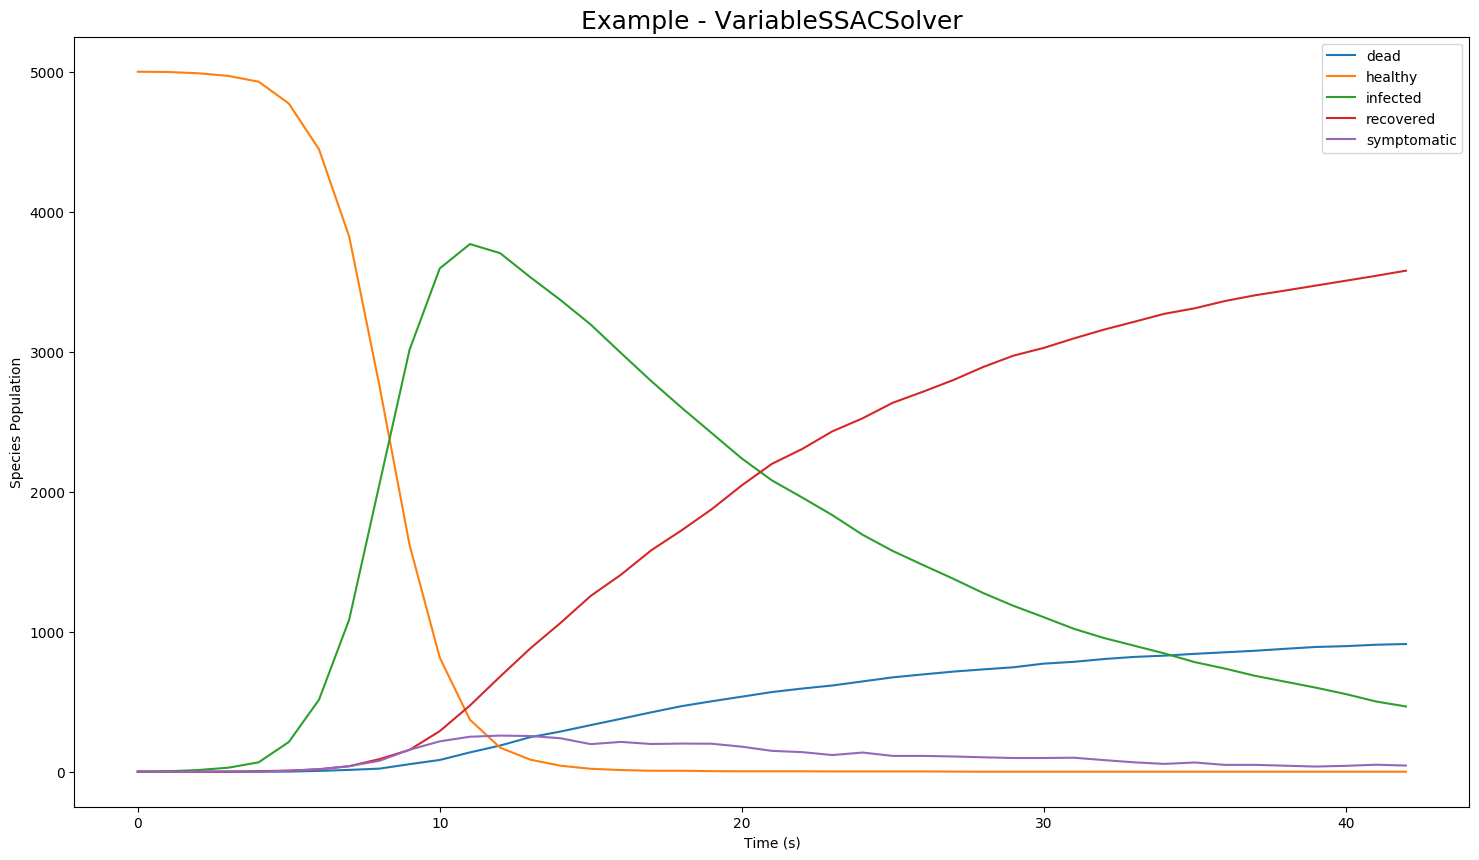

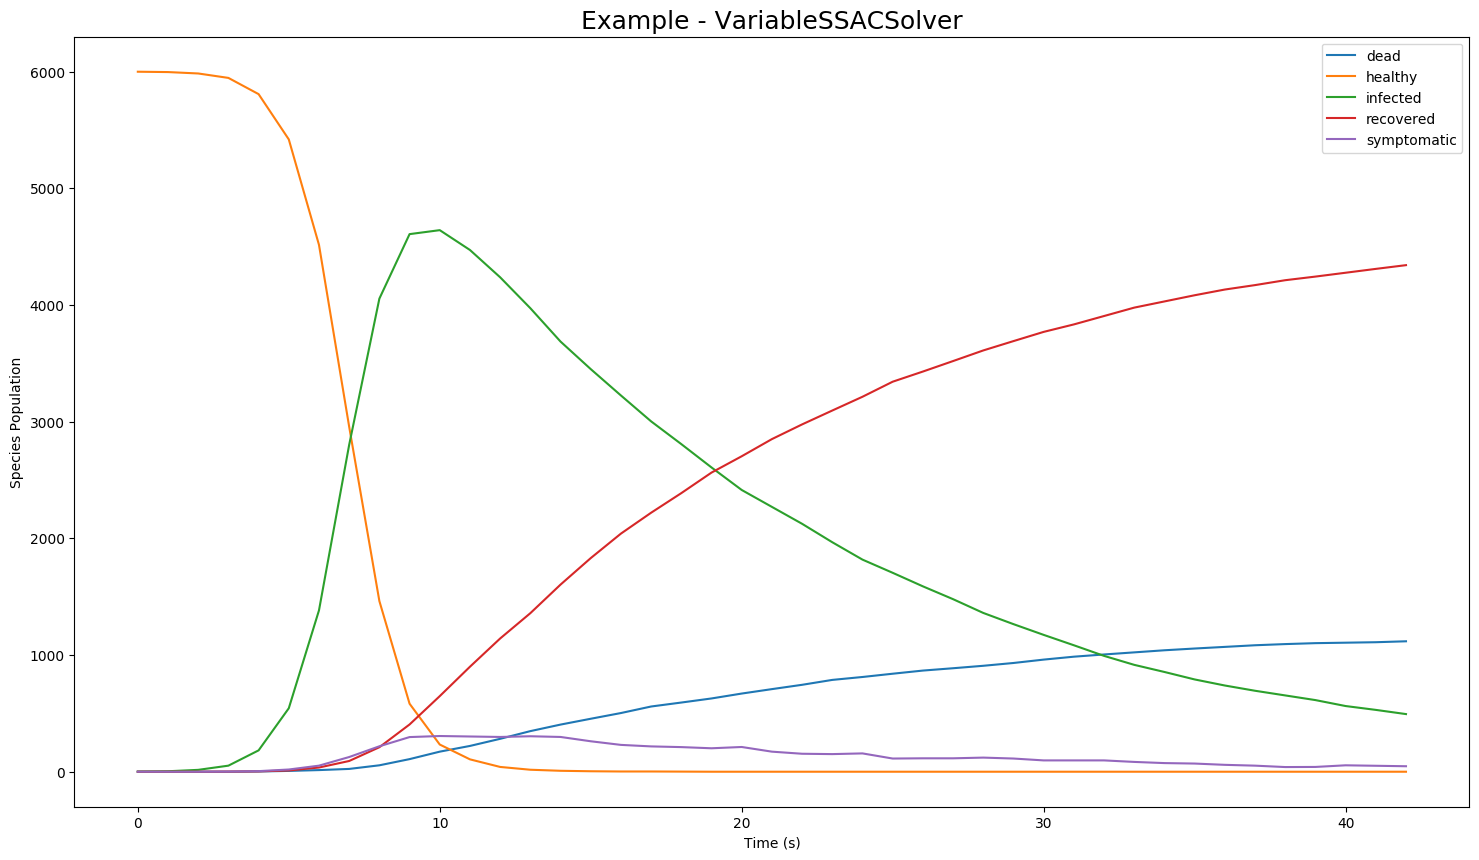

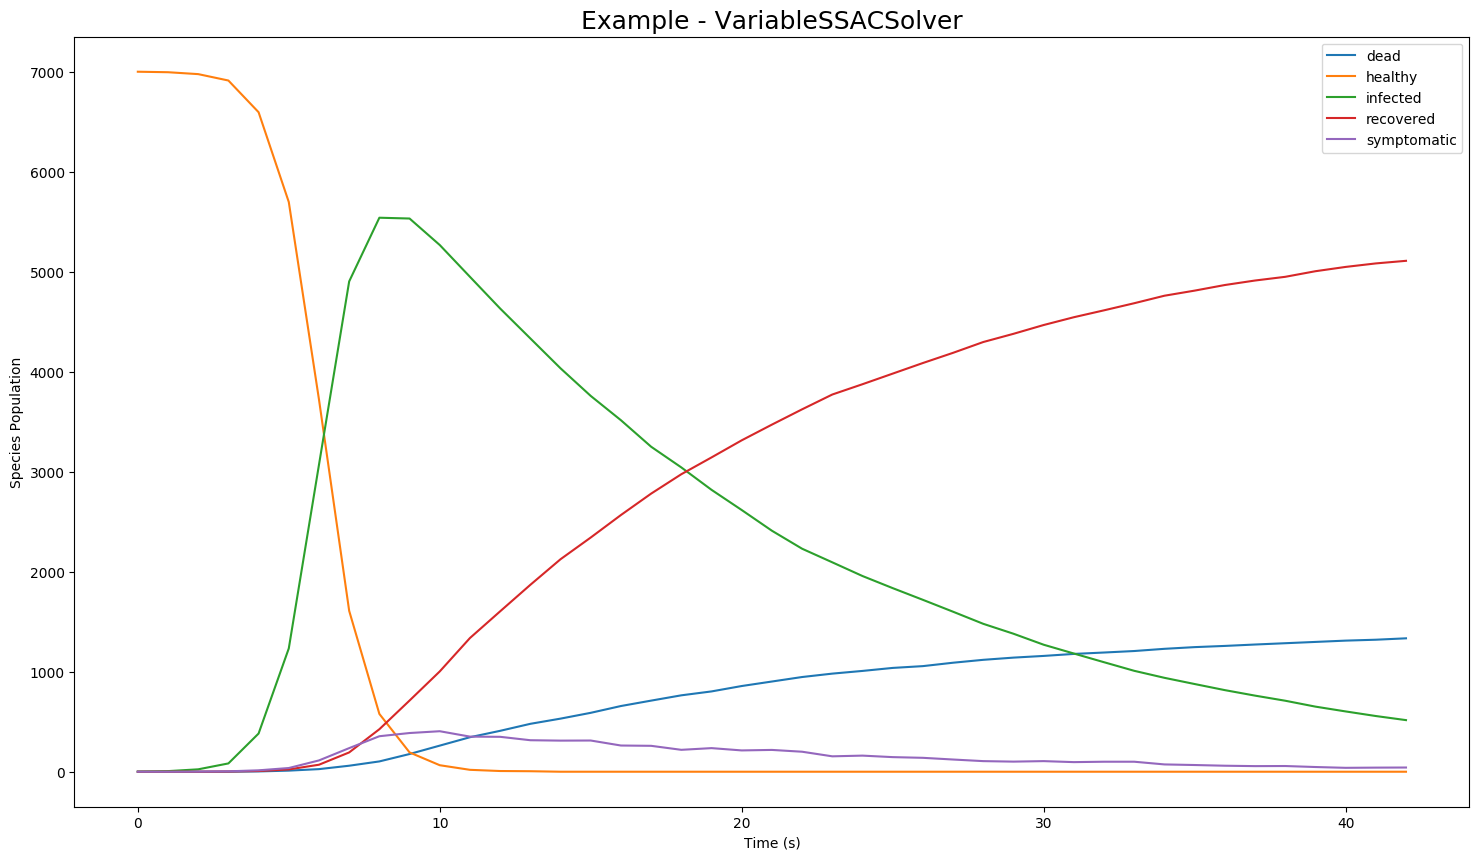

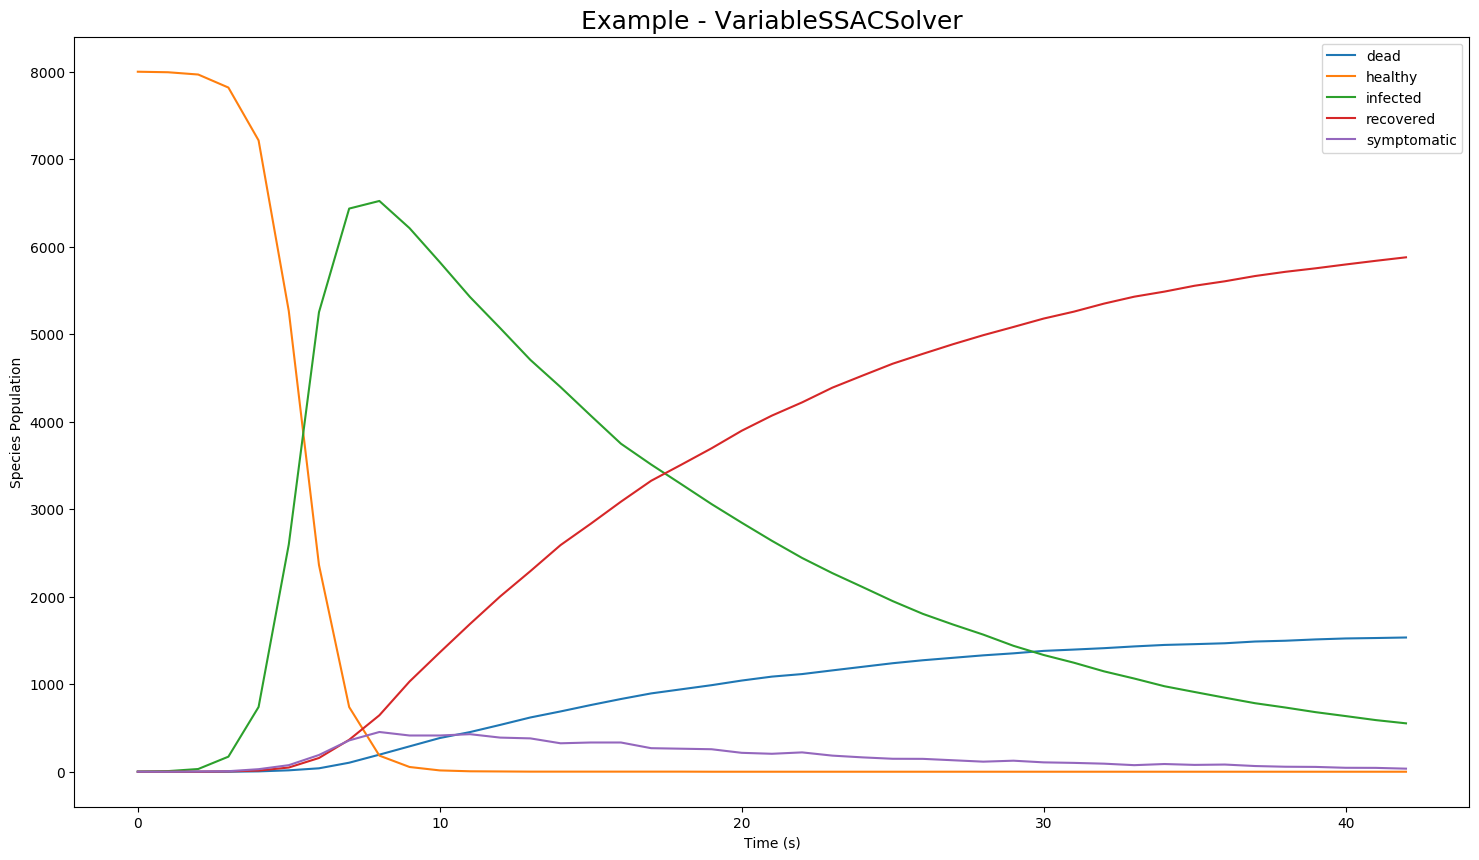

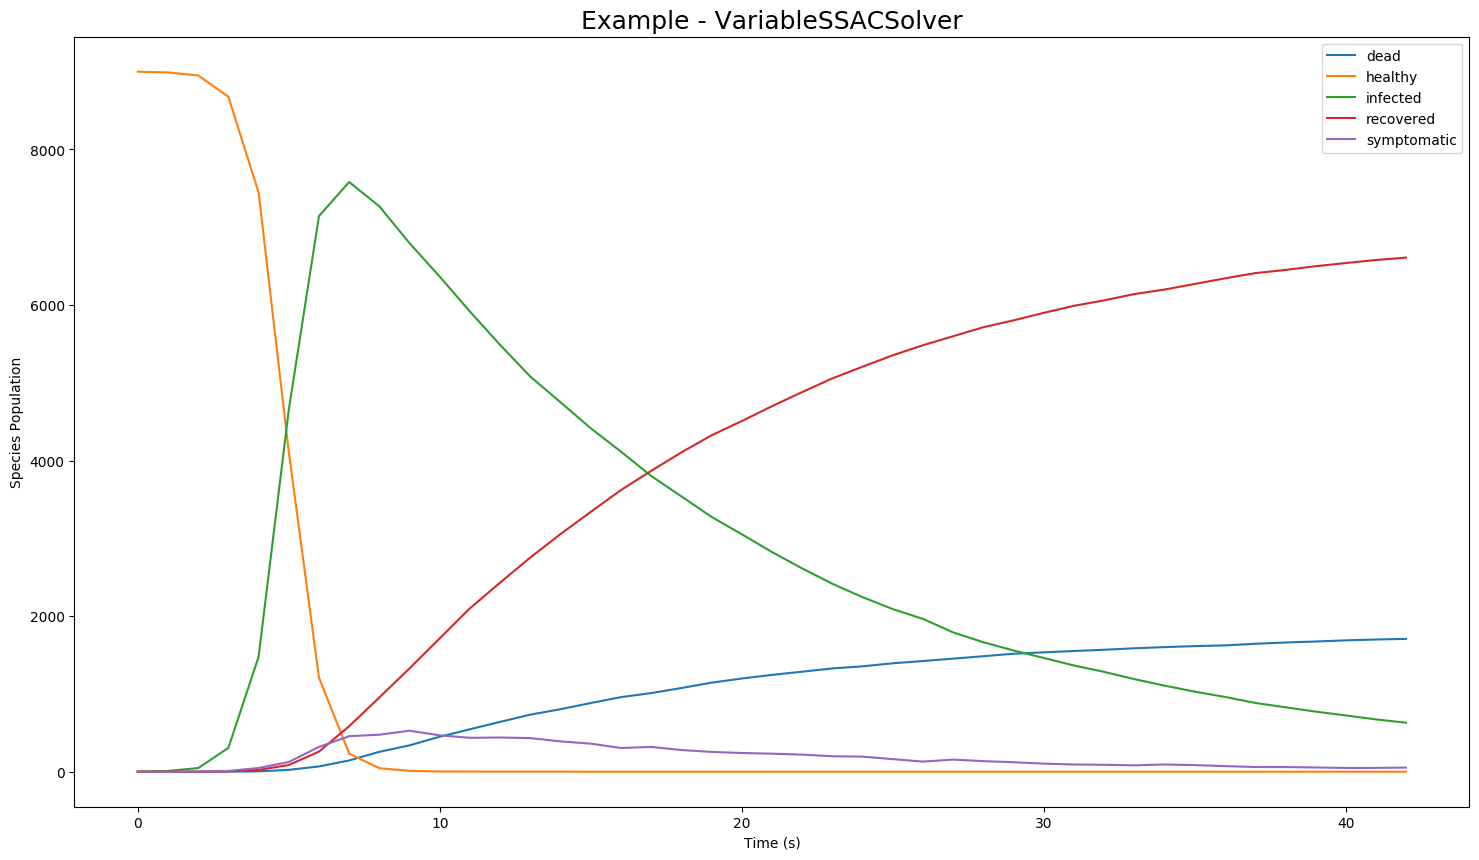

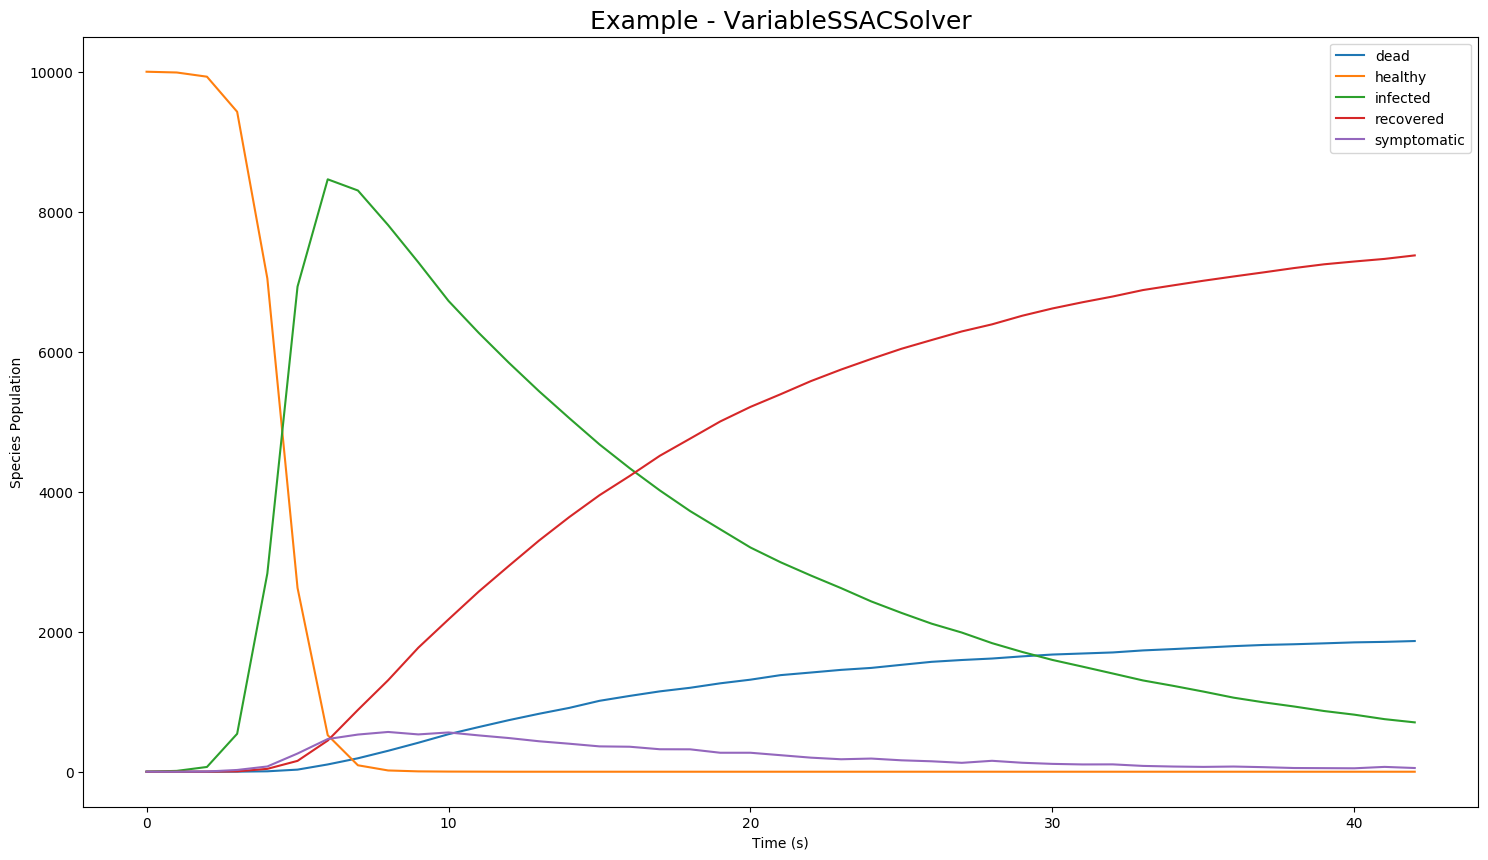

In [7]:
for r in results:
    r.plot()

In [8]:
# Here, a parameter value is modified over multiple simulations.  Notice how the method for
# sweeping over parameters is identical to sweeping over species initial values.

results = []
# Here we will iterate over multiple parameter values
def iterate_parameter():
    for i in range(1, 6):
        # Call model.run with keyword argument variables
        results.append(model.run(solver=solver, variables={'infect': 0.0001 * i}))
        # This will update the value of the 'infect' parameter for this simulation only
%time iterate_parameter()

CPU times: user 6.06 ms, sys: 27.9 ms, total: 34 ms
Wall time: 103 ms


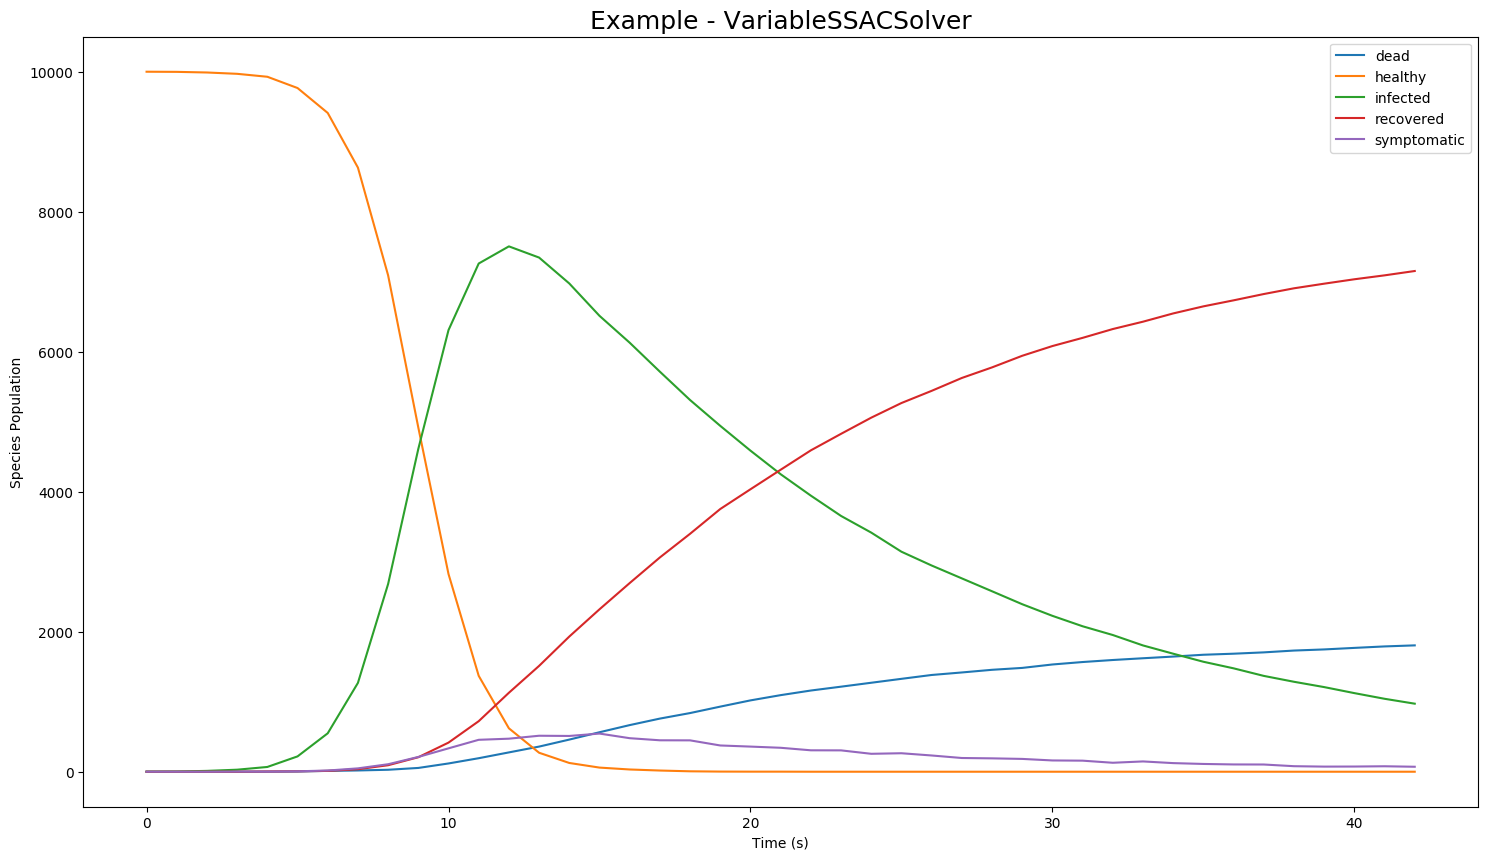

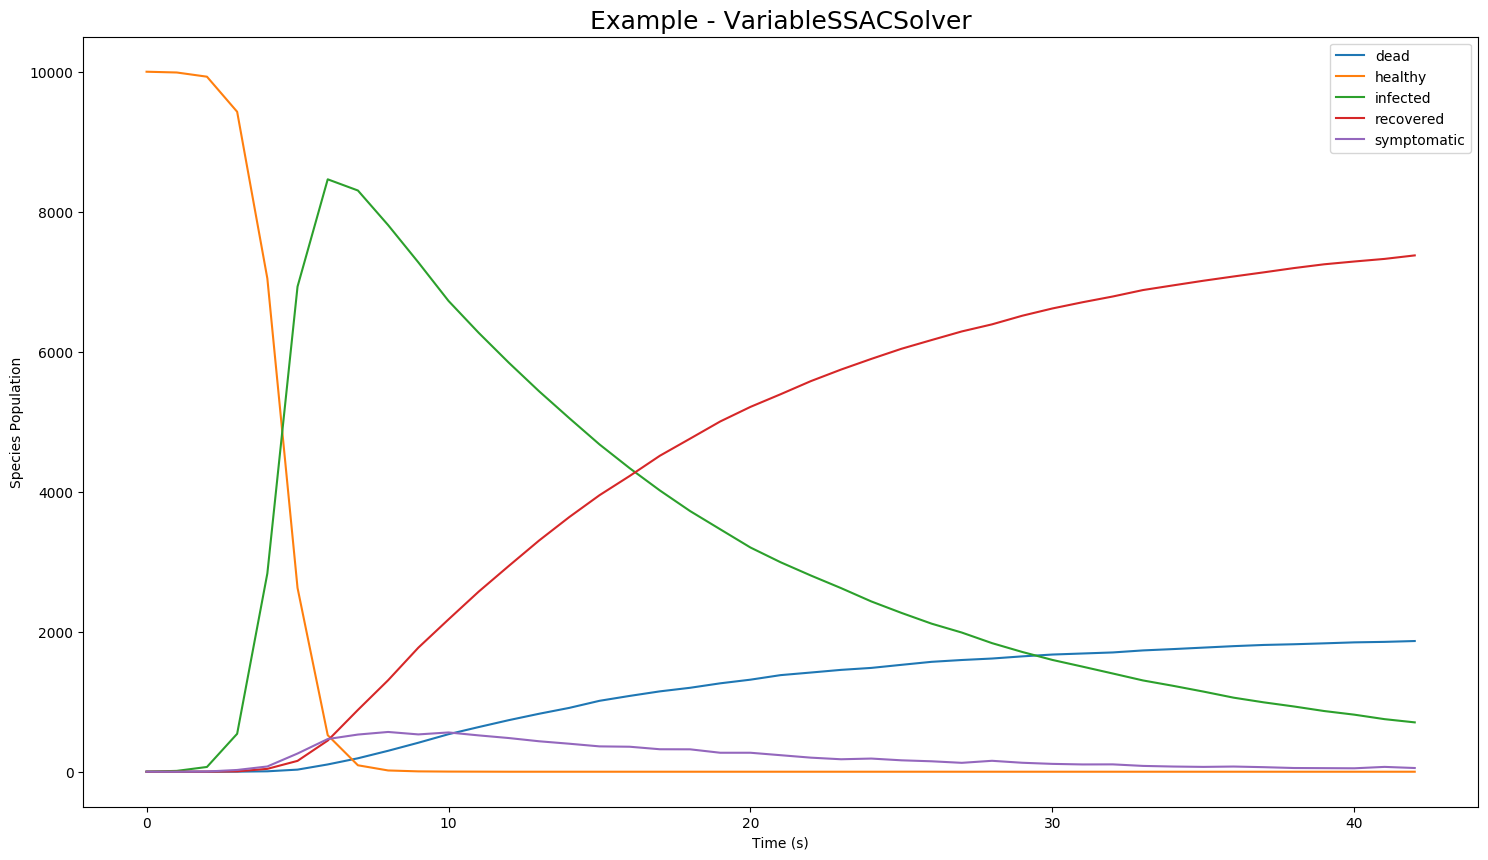

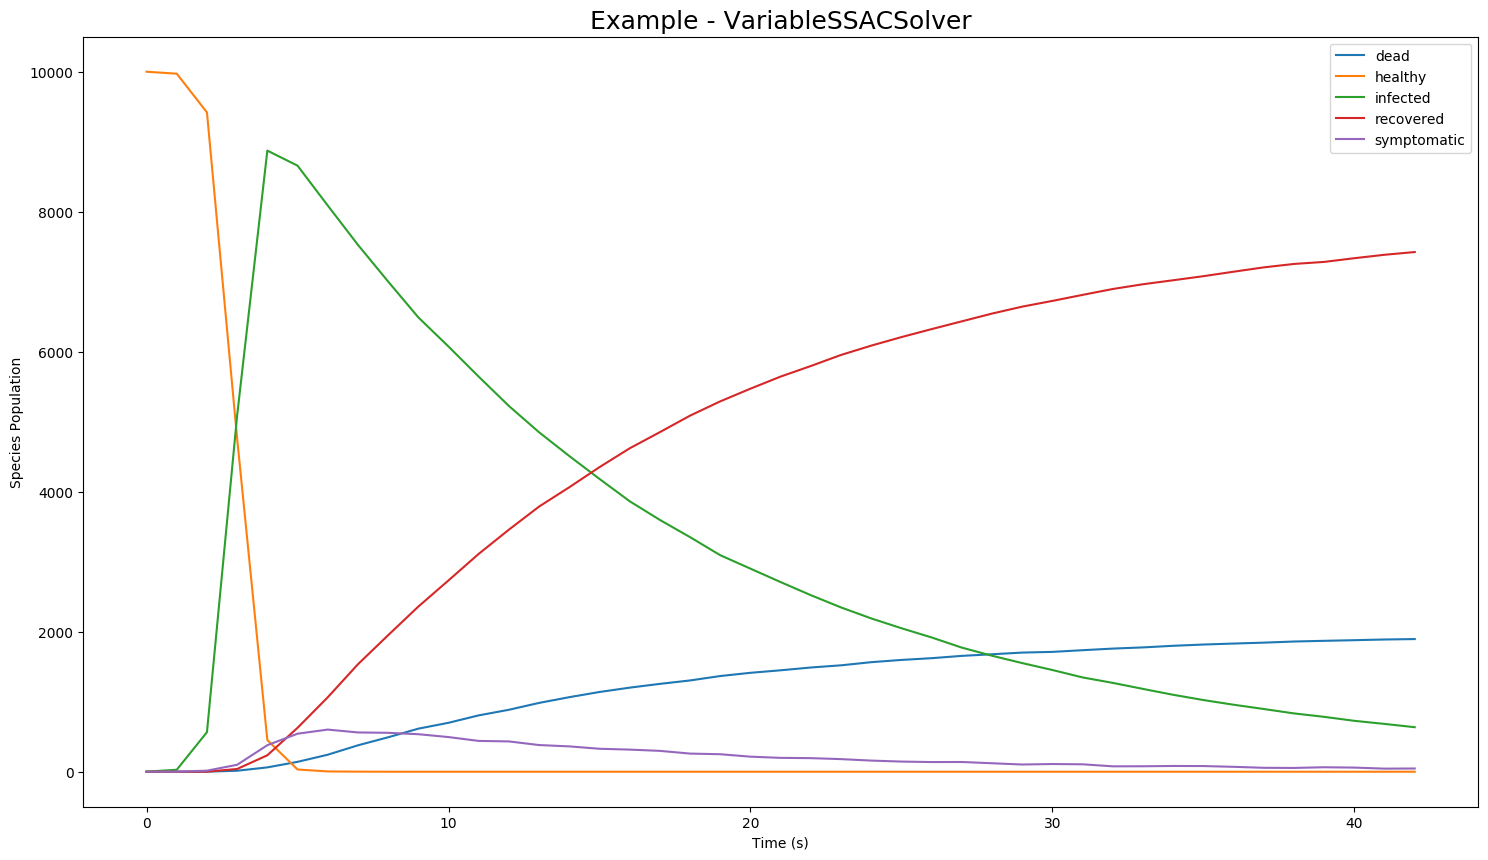

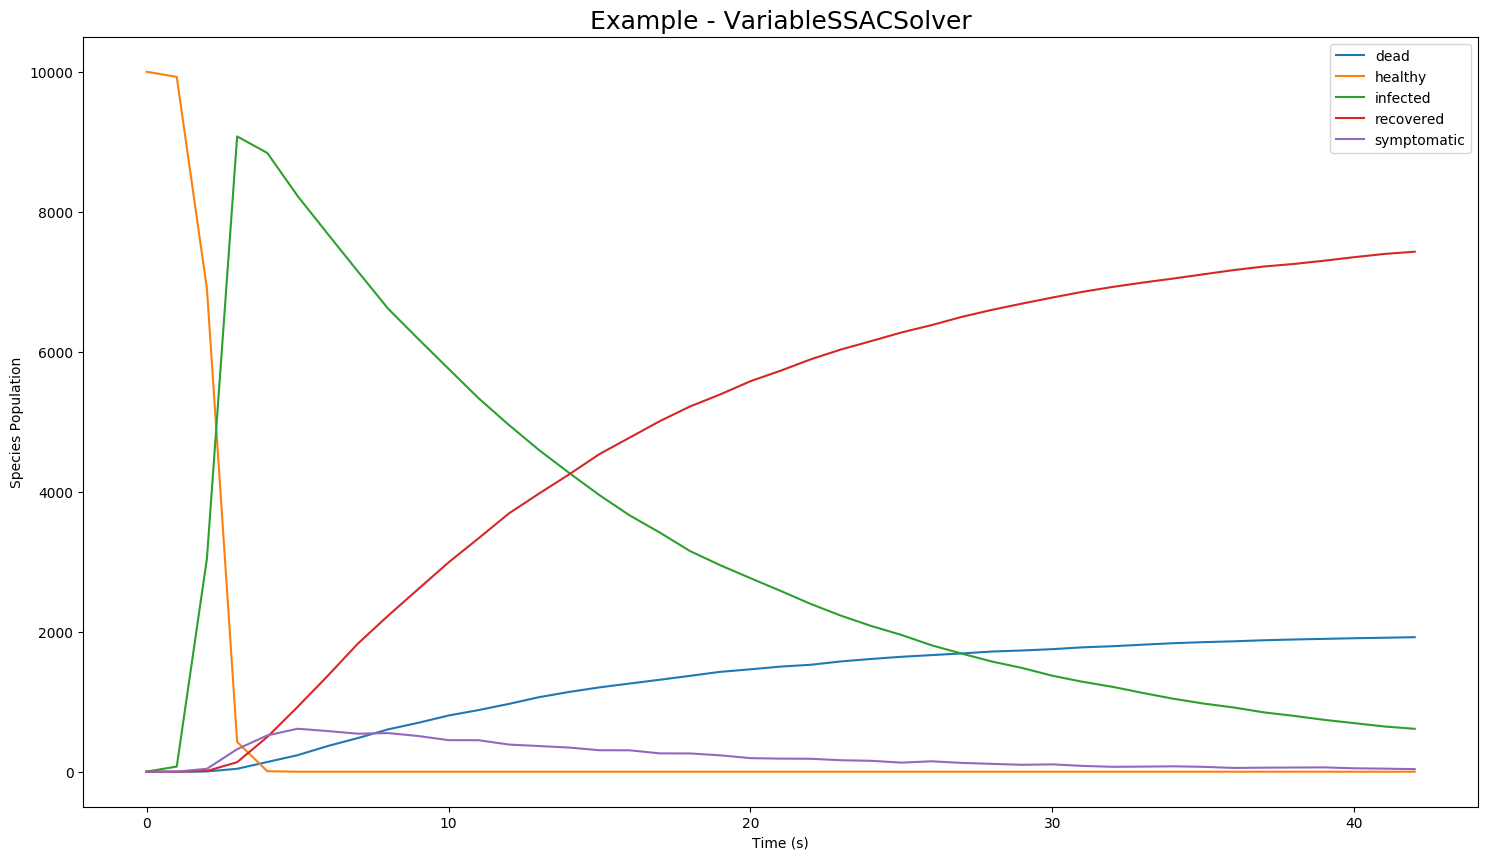

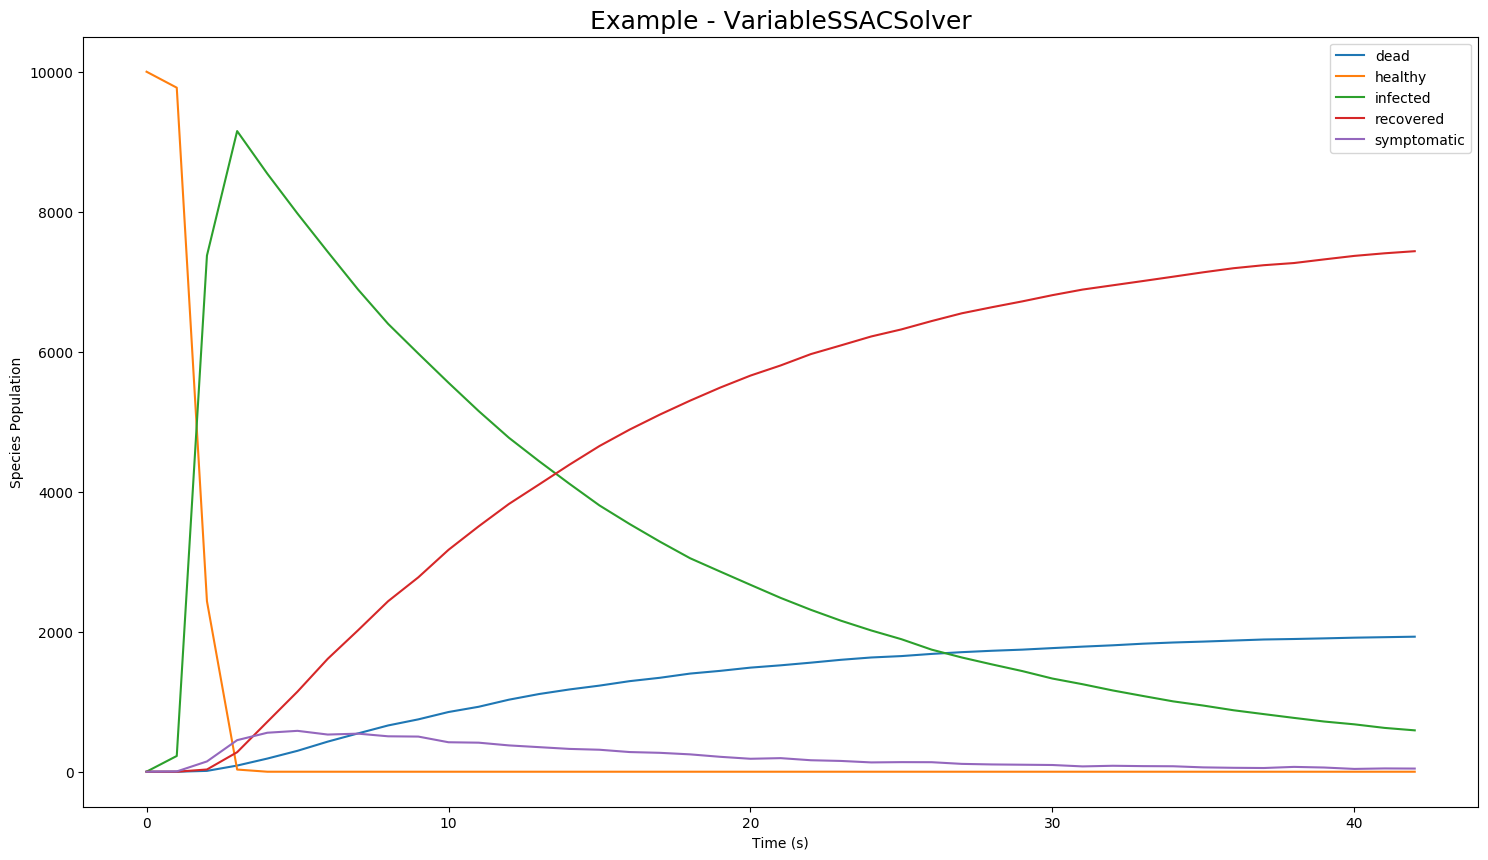

In [9]:
for r in results:
    r.plot()

In [10]:
# Finally, let's sweep over a species and a parameter at the same time.

results = []
# Here we will iterate over multiple species and parameter values
def iterate_multiple_values():
    for i in range(1, 6):
        # Call model.run with keyword argument variables
        results.append(model.run(solver=solver, variables={'healthy': (i+4)*1000, 'infect':0.0001*i}))
%time iterate_multiple_values()

CPU times: user 7.66 ms, sys: 28.3 ms, total: 36 ms
Wall time: 96.9 ms


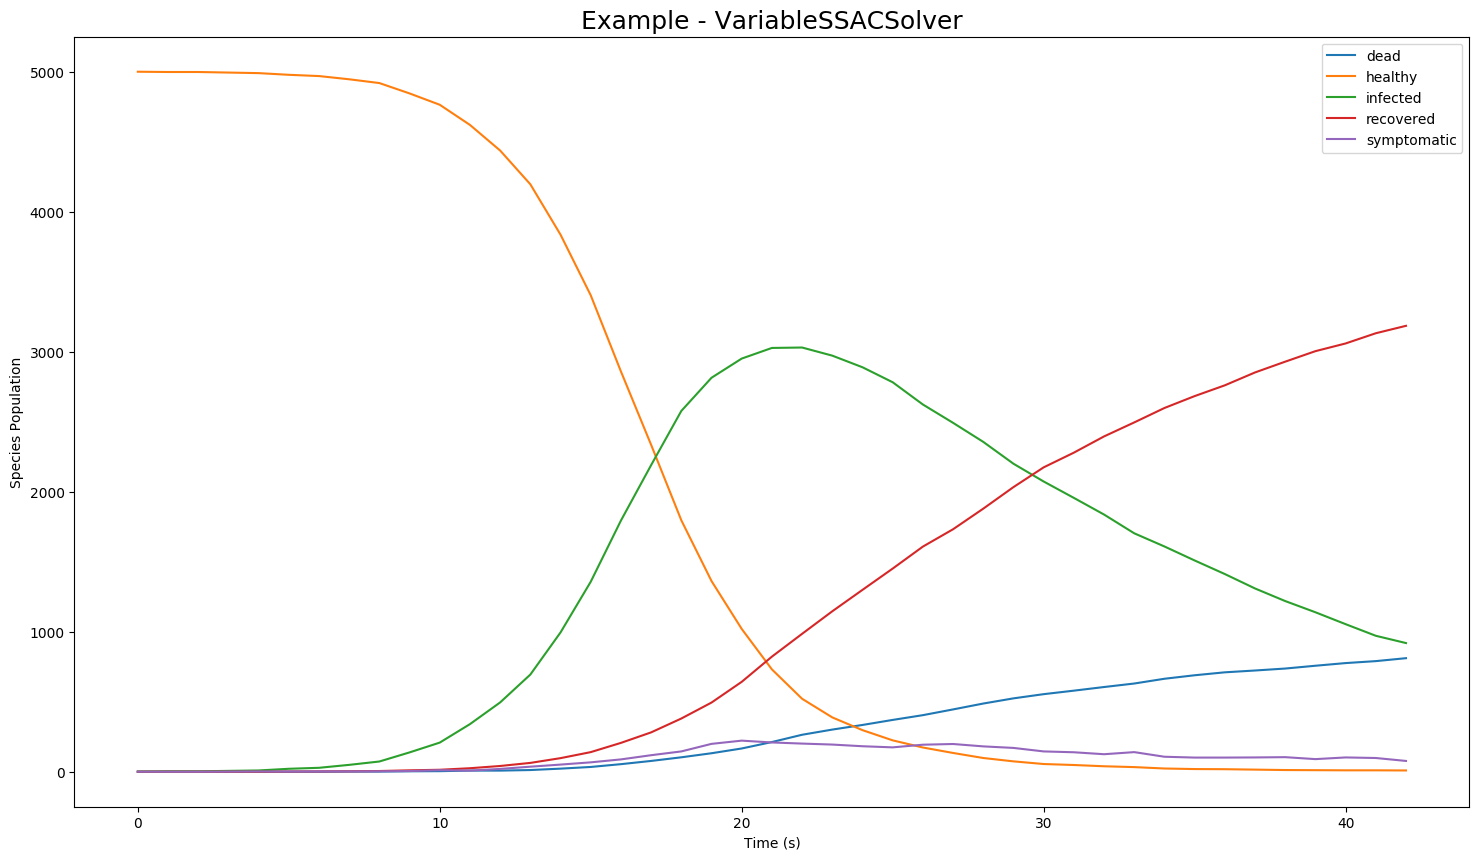

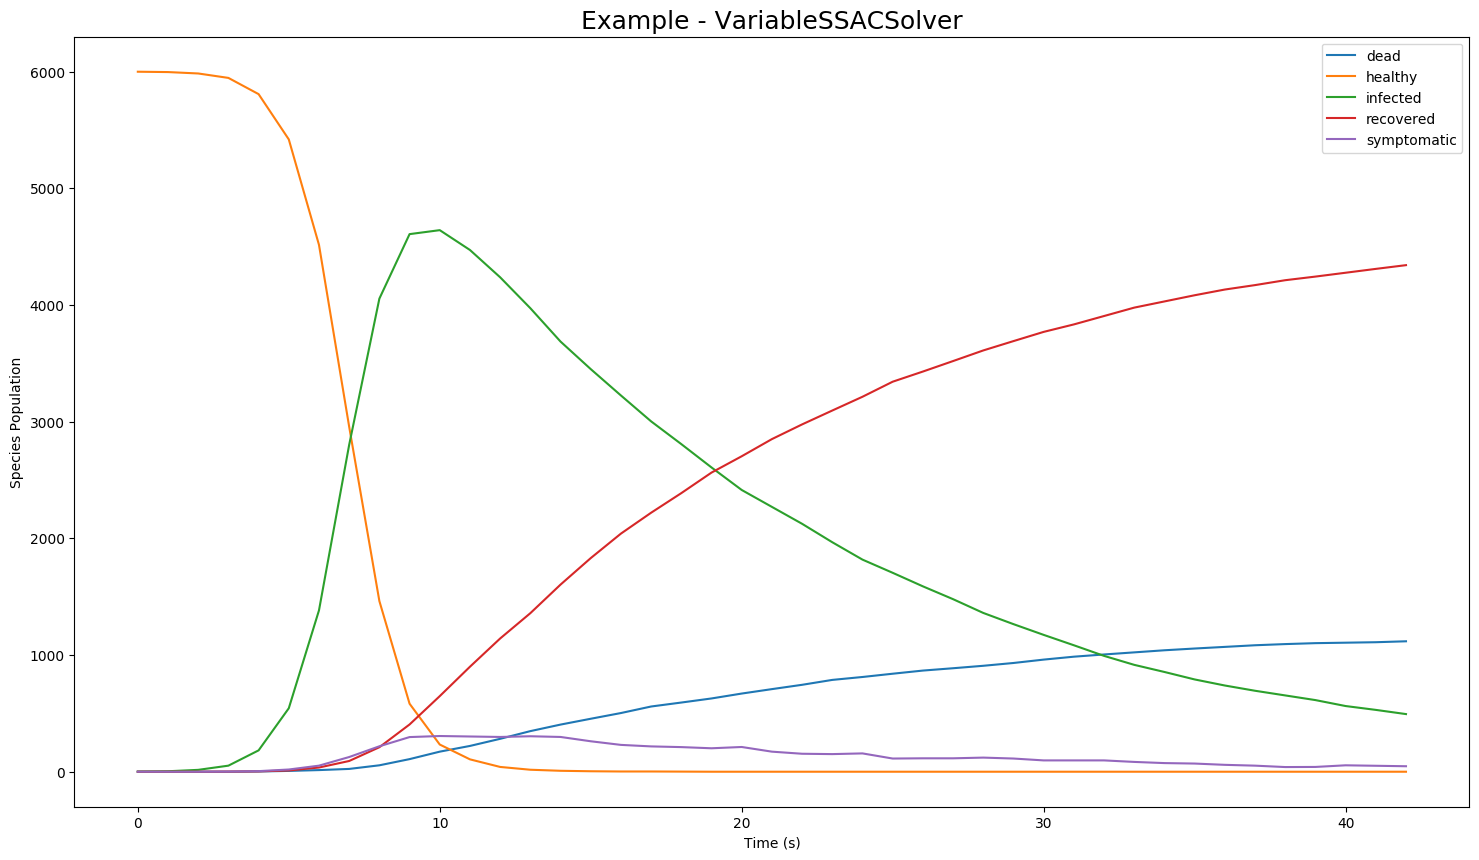

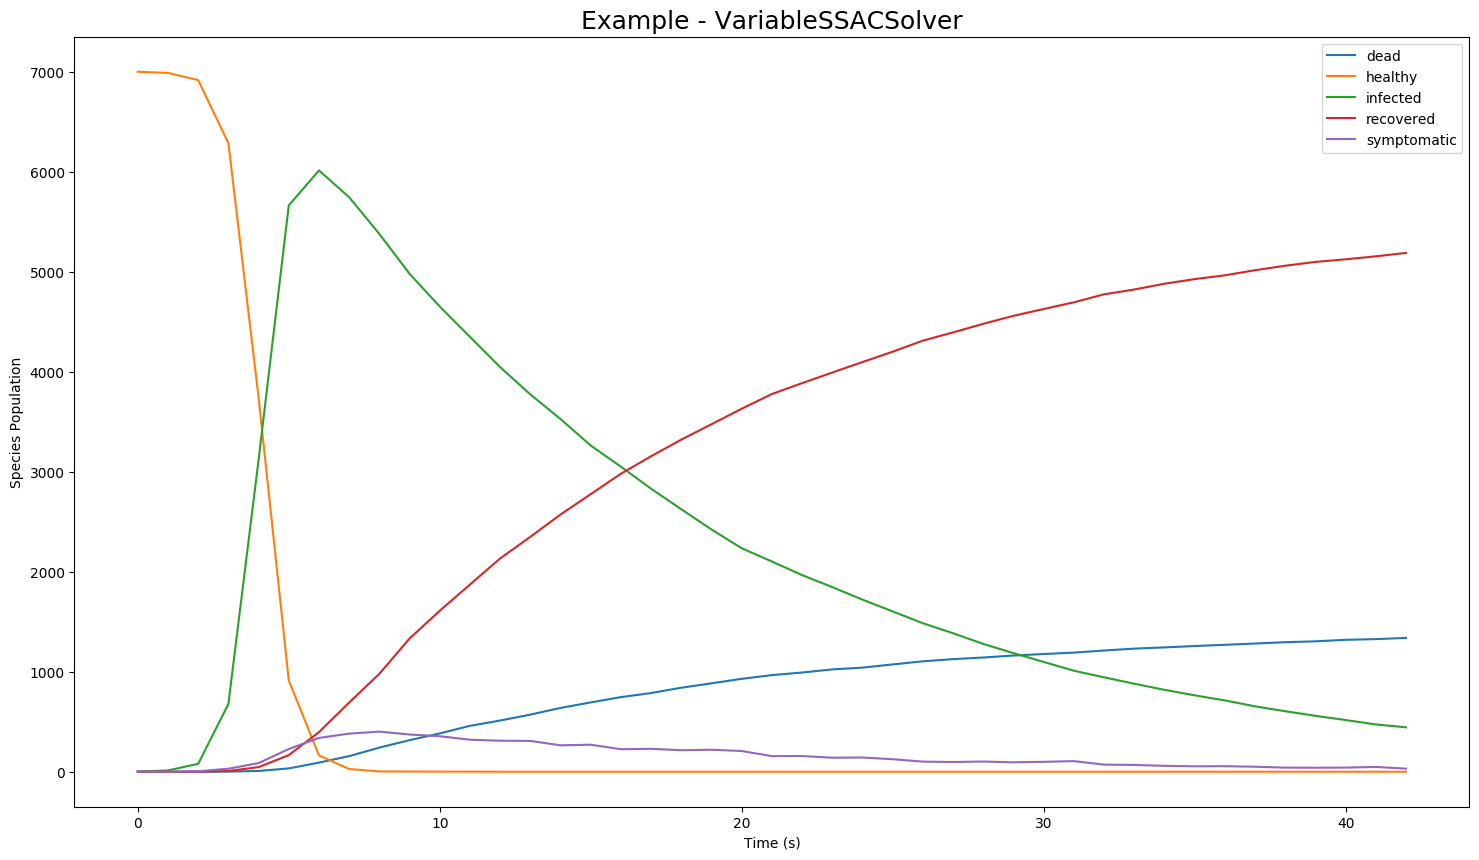

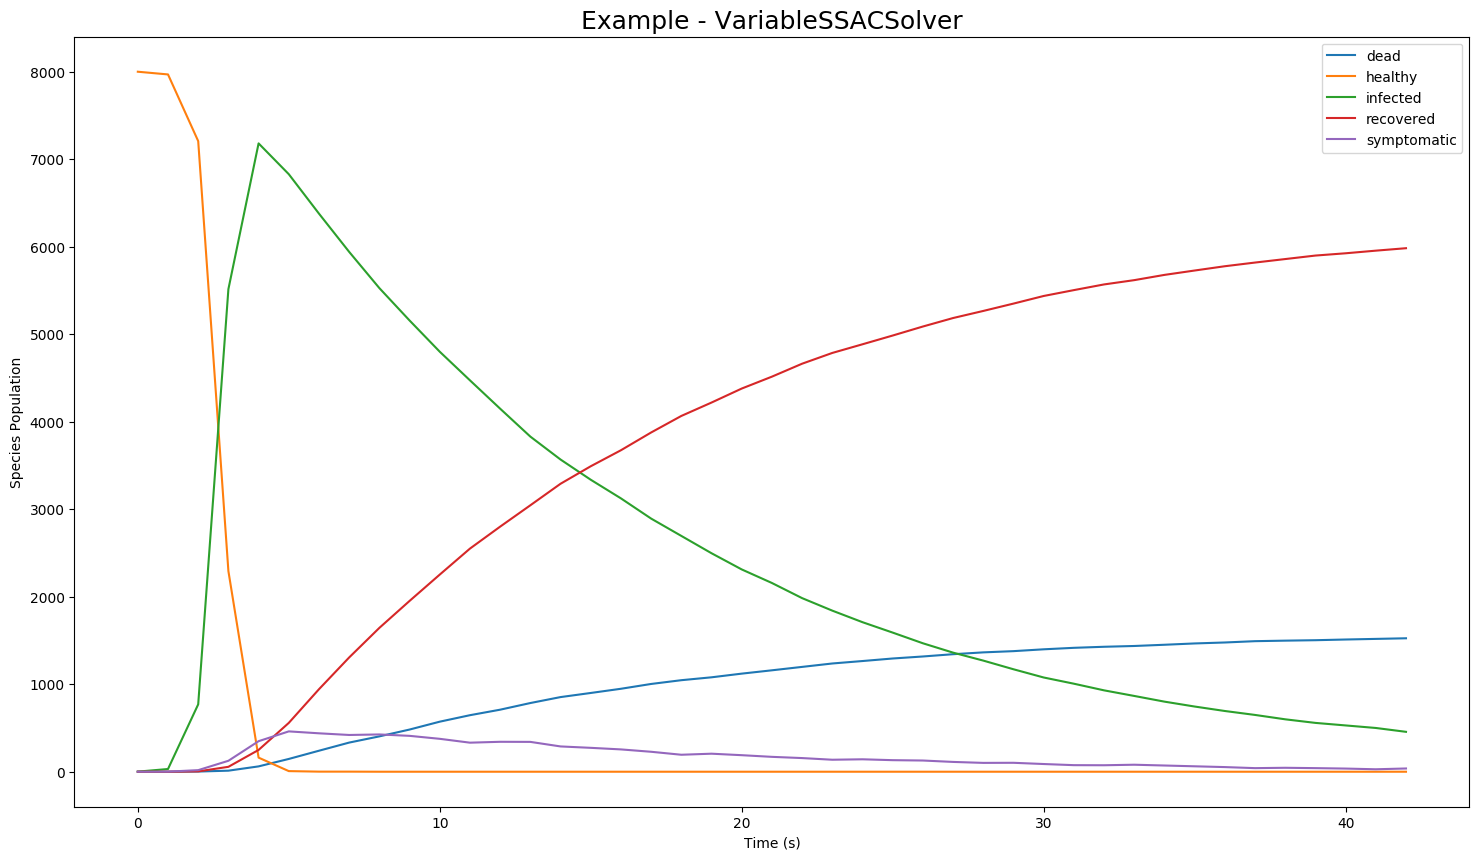

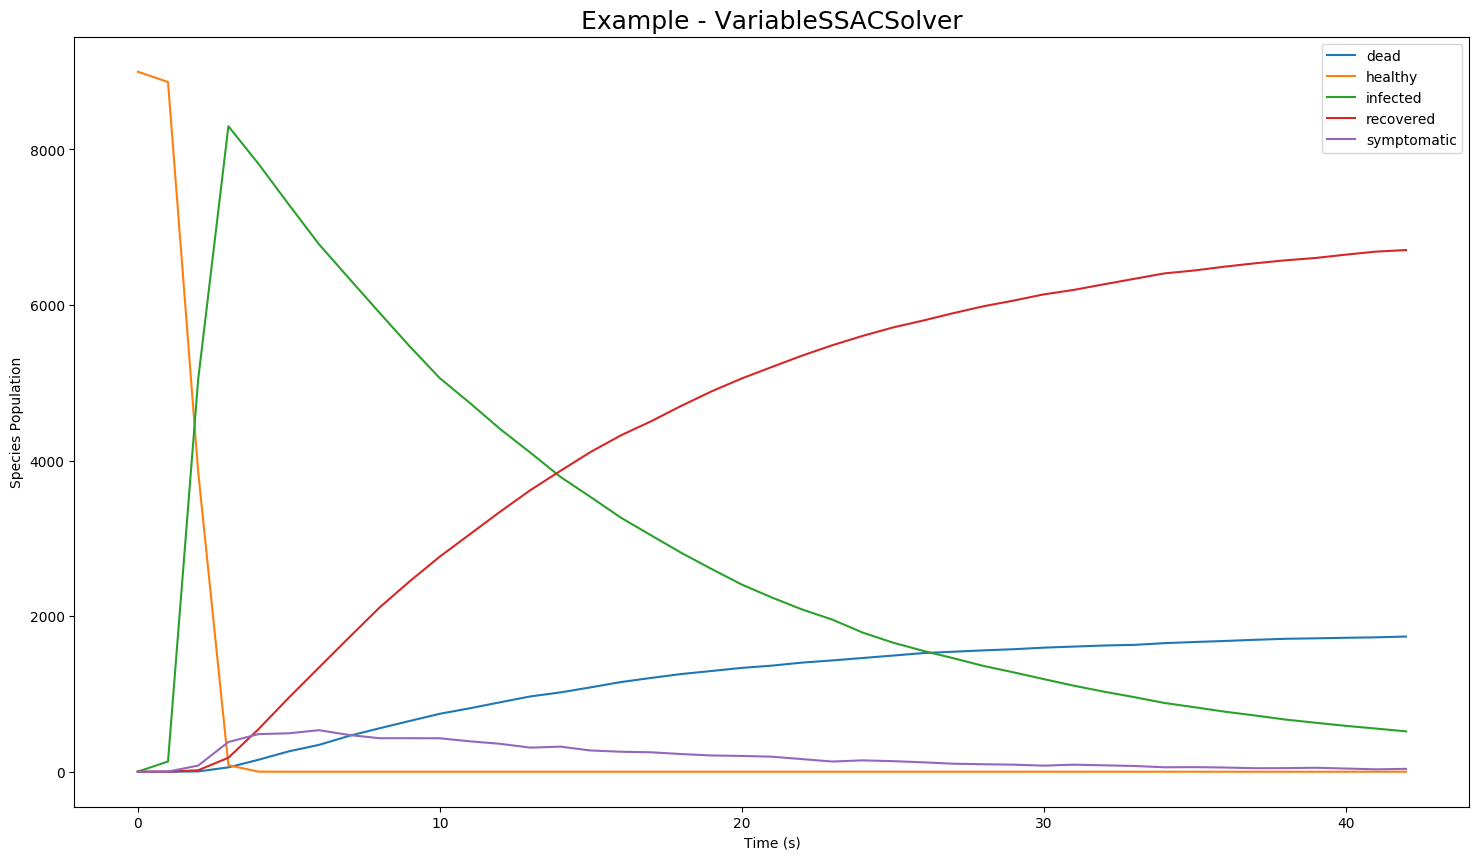

In [11]:
for r in results:
    r.plot()